In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
import time
import matplotlib.pyplot as plt

from datetime import datetime
import zipfile

In [2]:
zf = zipfile.ZipFile('Extract2.zip') 
veh_mess = pd.read_csv(zf.open('VehicleMessages.csv'))
patterns = pd.read_csv(zf.open('Patterns.csv'))
perf_work = pd.read_csv(zf.open('PerformedWork.csv'))
stops = pd.read_csv(zf.open('Stops.csv'))
traces = pd.read_csv(zf.open('Traces.csv'))
veh_events = pd.read_csv(zf.open('VehicleEvents.csv'))

In [58]:
pat_concat = perf_work[['date', 'workid', 'patternId']]
pat_concat.rename(index=str, columns = {'workid': 'id'}, inplace='True')

veh_events2 = pat_concat.merge(veh_events, how = 'inner', on = ['date', 'id'])

C:\Users\Jessica\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [3]:
pat_dict = {}

for i_d in patterns.id.unique():
    pat_dict[i_d] = list(patterns.loc[patterns.id == i_d].stopCode.values)

In [5]:
def sort_dict_by_value_len(dict_):
    return sorted(dict_.items(), key=lambda kv: (len(kv[1]), kv[0]))
sorted_dict = sort_dict_by_value_len(pat_dict)

In [3]:
# veh_mess.timeReported = pd.to_datetime(veh_mess.timeReported)
# perf_work.date = pd.to_datetime(perf_work.date, format='%Y%m%d')
# veh_events.date = pd.to_datetime(veh_events.date, format='%Y%m%d')
# veh_events.actualArrival = pd.to_datetime(veh_events.actualArrival)
# veh_events.actualDeparture = pd.to_datetime(veh_events.actualDeparture)

In [10]:
def progressBar(value, endvalue, bar_length=20):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    print("\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))), end='\r')

In [4]:
def secs_late(df, number):
    a = df[~pd.isnull(df.actualArrival)].actualArrival.values[number]
    a = a[11:]        
#     print(a[:2])
    secs_arrival = int(a[0:2])*60*60 + int(a[3:5])*60 + int(a[6:])
    if a[:2] == '00':
        secs_arrival += 86400
#     print(secs_arrival)
    secs_aimed = df[~pd.isnull(df.actualArrival)].aimedArrival.values[number]
    
    return secs_arrival - secs_aimed

In [29]:
def ssm_to_time(ssm):
    return time.strftime('%H:%M:%S', time.gmtime(86580))

In [56]:
def find_next_node(pat, stopcode):
    """ Fn to return the next stop code the bus will go to. """
#     dict_index = pat_dict[pat].index(stopcode)
    dict_index = np.where(np.array(pat_dict[pat]) == stopcode)[0]
    if len(dict_index) == 1:
        return pat_dict[pat][dict_index[0]+1]
    else:
        return "Go to 'find_next_node' fn. This stop appears twice in the pattern."

# Plot of lateness

In [7]:
wanted_stops = pat_dict['170_86'][10:15]
print(len(wanted_stops))
wanted_stops

5


['1280POA11589',
 '1280POA11590',
 '1280POA11593',
 '1280POX38425',
 '1280POA11597']

In [8]:
more_stops = veh_events.loc[veh_events['stopCode'].isin(wanted_stops) & ~pd.isnull(veh_events.actualArrival)]

In [11]:
%%time
## Find the difference for all of these points
lateness = []
for i in range(len(more_stops)):
    lateness.append(secs_late(more_stops, i))
#     print(i/len(one_stop)*100)
    progressBar(i, len(more_stops))
#     if secs_late(more_stops, i) <= -120:
#         print(i)

Wall time: 4min 59s---------->] 100%


In [12]:
more_stops.date = pd.to_datetime(more_stops.date, format='%Y%m%d')
more_stops.actualArrival = pd.to_datetime(more_stops.actualArrival)
# add weekdays and hour
more_stops['weekday'] = more_stops['actualArrival'].dt.dayofweek
more_stops['hour'] = more_stops['actualArrival'].dt.hour

C:\Users\Jessica\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\Jessica\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Jessica\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

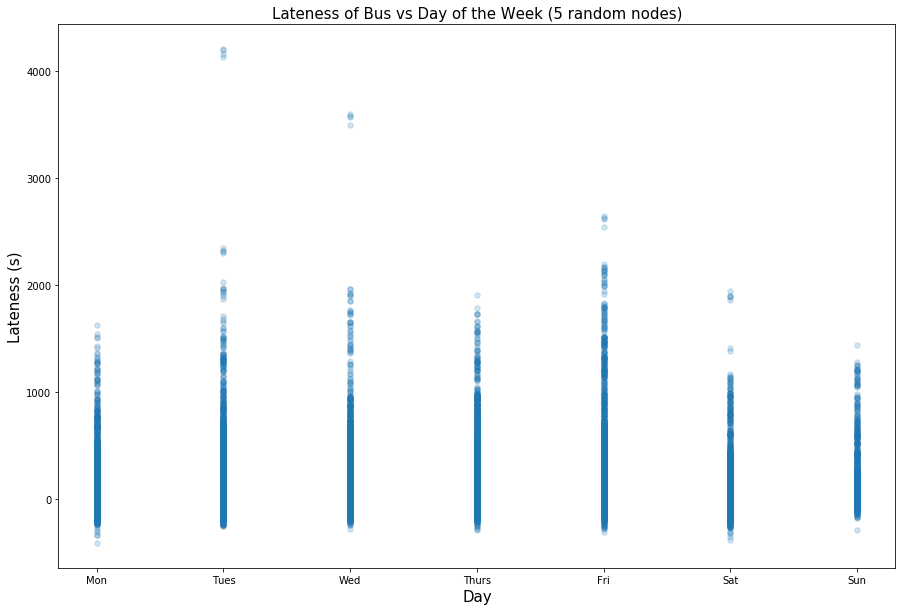

In [27]:
plt.figure(figsize = (15, 10))
plt.scatter(more_stops.weekday, lateness, s=30, alpha=0.2)

x1 = [0, 1, 2, 3, 4, 5, 6]
days = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
ax = plt.axes()
ax.set_xticks(x1)
ax.set_xticklabels(days)

plt.title('Lateness of Bus vs Day of the Week (5 random nodes)', fontsize=15)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Lateness (s)', fontsize=15)

plt.show()

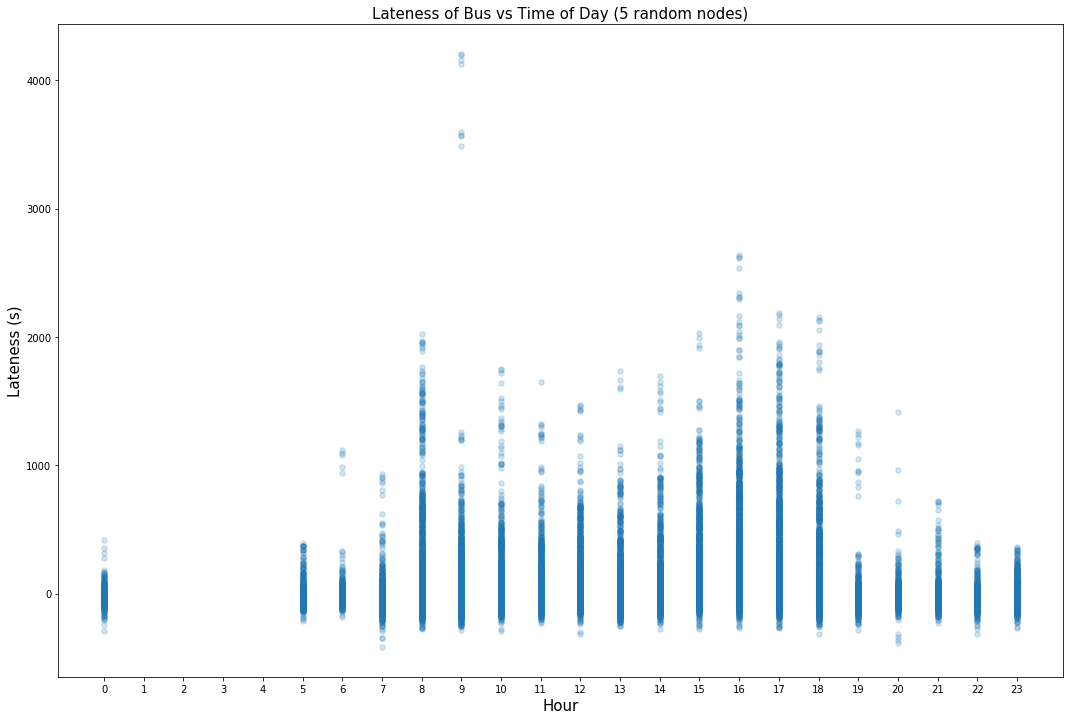

In [28]:
plt.figure(figsize = (18, 12))
plt.scatter(more_stops.hour, lateness, s=30, alpha=0.2)

plt.xticks(np.arange(0, 24, 1.0))

plt.title('Lateness of Bus vs Time of Day (5 random nodes)', fontsize=15)
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Lateness (s)', fontsize=15)

plt.show()

## For route 167_319

In [30]:
wanted_stops = pat_dict['167_319']
print(len(wanted_stops))
wanted_stops

5


['1290BOB20465', '1290BOA05335', '1290DOB21054', '1200POA11728', '9200BOH1']

In [31]:
more_stops2 = veh_events.loc[veh_events['stopCode'].isin(wanted_stops) & ~pd.isnull(veh_events.actualArrival)]

In [32]:
## Find the difference for all of these points
lateness2 = []
for i in range(len(more_stops2)):
    lateness2.append(secs_late(more_stops2, i))
#     print(i/len(one_stop)*100)
    progressBar(i, len(more_stops2))

In [33]:
more_stops2.date = pd.to_datetime(more_stops2.date, format='%Y%m%d')
more_stops2.actualArrival = pd.to_datetime(more_stops2.actualArrival)
# add weekdays and hour
more_stops2['weekday'] = more_stops2['actualArrival'].dt.dayofweek
more_stops2['hour'] = more_stops2['actualArrival'].dt.hour

C:\Users\Jessica\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Jessica\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


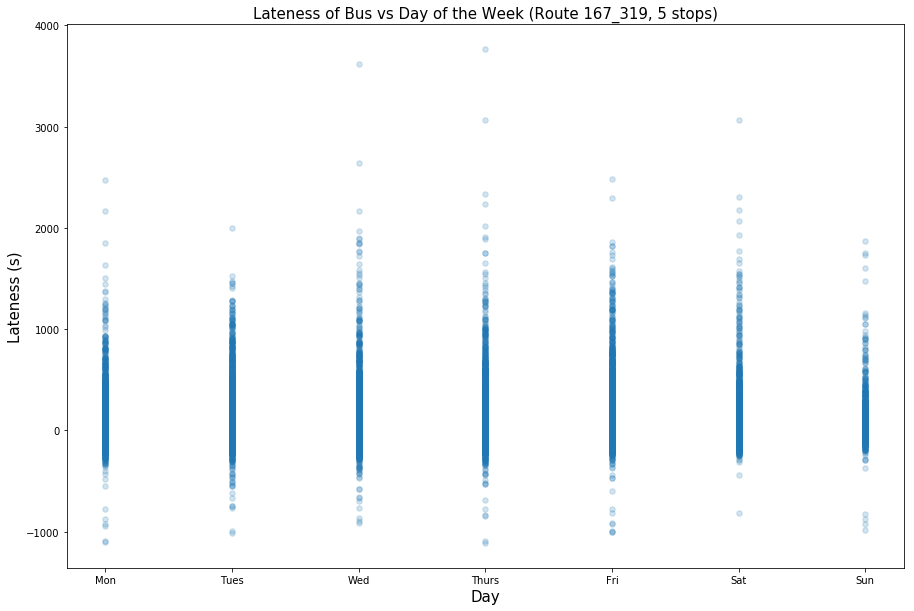

In [34]:
plt.figure(figsize = (15, 10))
plt.scatter(more_stops2.weekday, lateness2, s=30, alpha=0.2)

x1 = [0, 1, 2, 3, 4, 5, 6]
days = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
ax = plt.axes()
ax.set_xticks(x1)
ax.set_xticklabels(days)

plt.title('Lateness of Bus vs Day of the Week (Route 167_319, 5 stops)', fontsize=15)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Lateness (s)', fontsize=15)

plt.show()

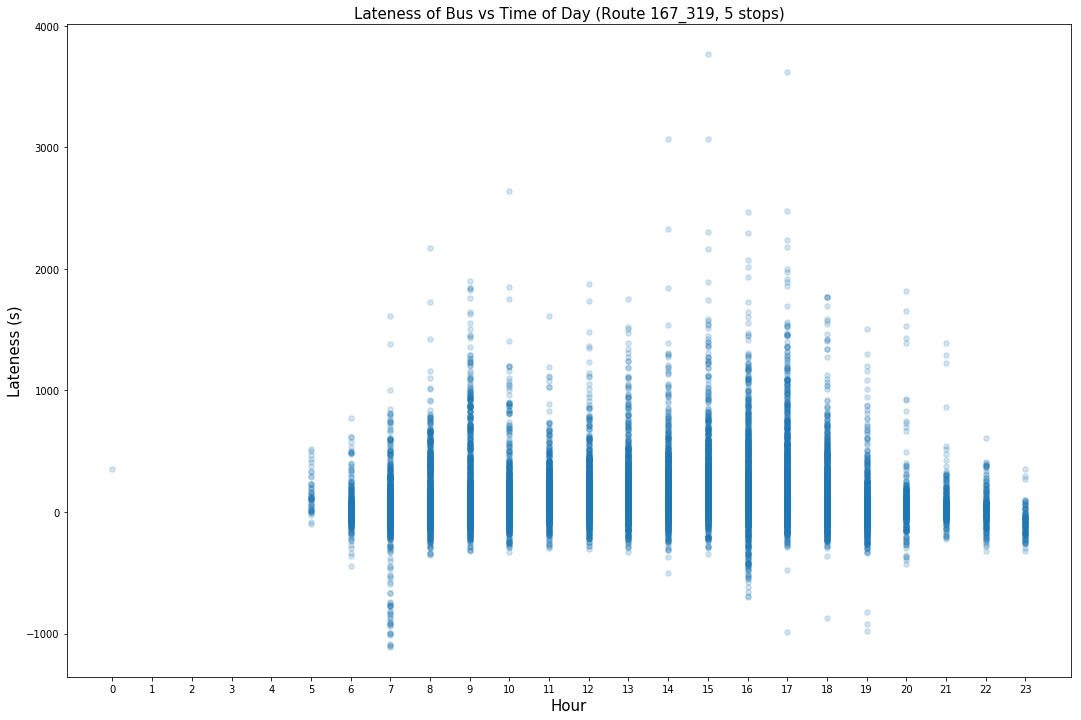

In [35]:
plt.figure(figsize = (18, 12))
plt.scatter(more_stops2.hour, lateness2, s=30, alpha=0.2)

plt.xticks(np.arange(0, 24, 1.0))

plt.title('Lateness of Bus vs Time of Day (Route 167_319, 5 stops)', fontsize=15)
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Lateness (s)', fontsize=15)

plt.show()

On this route buses are often early (i.e. the above graphs are not a mistake). Sometimes they wait but sometimes they leave a stop 10 minutes early...

## For route 167_316: Same problem as above

167_320, 170_270, 170_269

## For route 170_269

In [36]:
wanted_stops = pat_dict['170_269']
print(len(wanted_stops))
wanted_stops

6


['1200POA10447',
 '1200POA10445',
 '1200POA10442',
 '1200POA10440',
 '1200POA10419',
 '1200POA10416']

In [37]:
more_stops3 = veh_events.loc[veh_events['stopCode'].isin(wanted_stops) & ~pd.isnull(veh_events.actualArrival)]

In [38]:
## Find the difference for all of these points
lateness3 = []
for i in range(len(more_stops3)):
    lateness3.append(secs_late(more_stops3, i))
#     print(i/len(one_stop)*100)
    progressBar(i, len(more_stops3))

In [39]:
more_stops3.date = pd.to_datetime(more_stops3.date, format='%Y%m%d')
more_stops3.actualArrival = pd.to_datetime(more_stops3.actualArrival)
# add weekdays and hour
more_stops3['weekday'] = more_stops3['actualArrival'].dt.dayofweek
more_stops3['hour'] = more_stops3['actualArrival'].dt.hour

C:\Users\Jessica\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Jessica\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


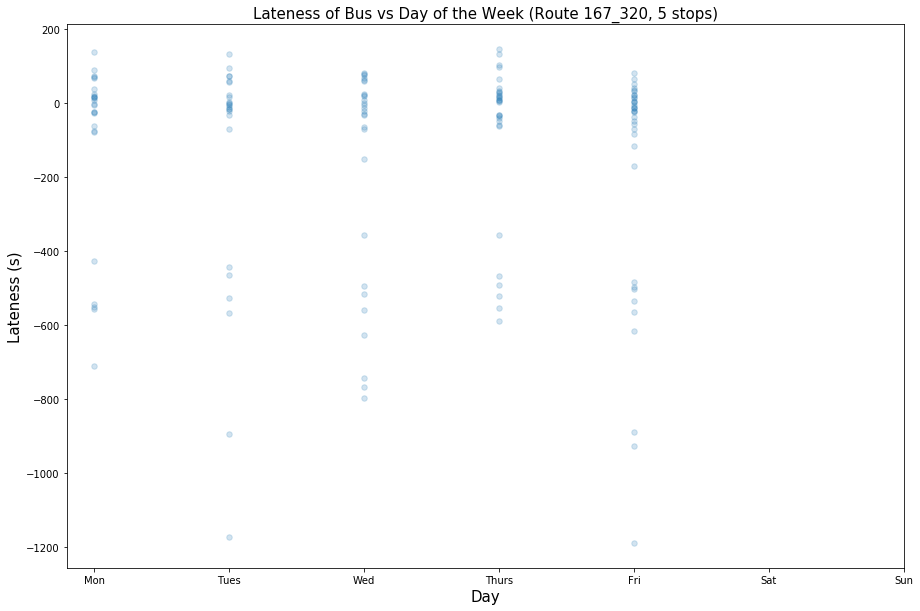

In [40]:
plt.figure(figsize = (15, 10))
plt.scatter(more_stops3.weekday, lateness3, s=30, alpha=0.2)

x1 = [0, 1, 2, 3, 4, 5, 6]
days = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
ax = plt.axes()
ax.set_xticks(x1)
ax.set_xticklabels(days)

plt.title('Lateness of Bus vs Day of the Week (Route 167_320, 5 stops)', fontsize=15)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Lateness (s)', fontsize=15)

plt.show()

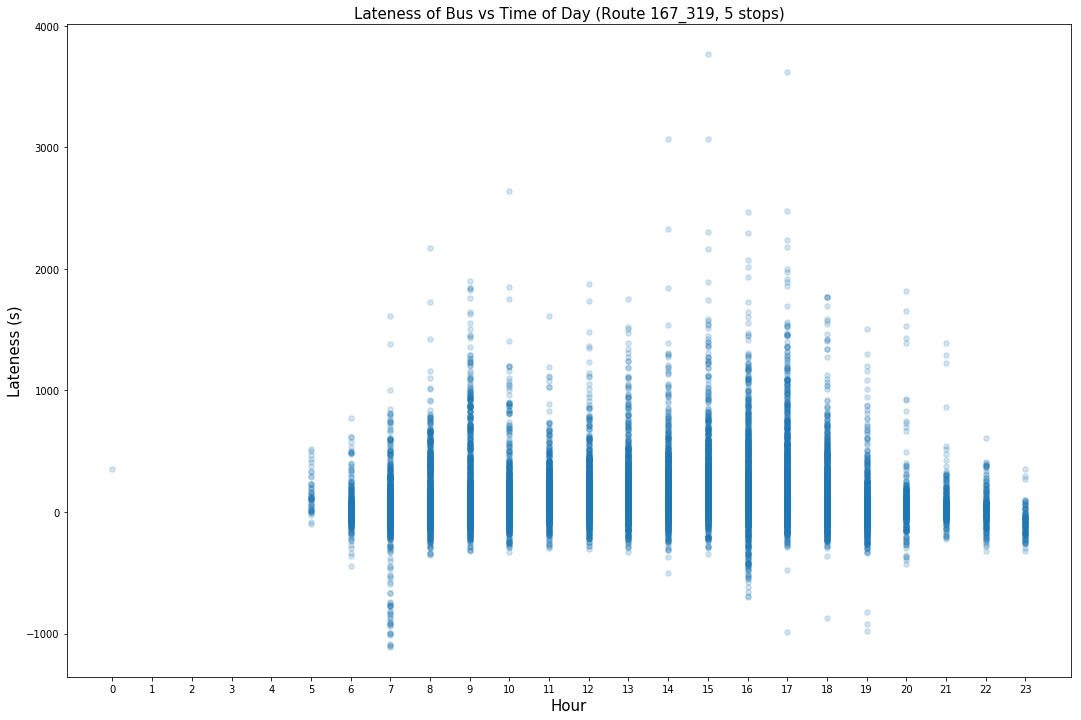

In [41]:
plt.figure(figsize = (18, 12))
plt.scatter(more_stops2.hour, lateness2, s=30, alpha=0.2)

plt.xticks(np.arange(0, 24, 1.0))

plt.title('Lateness of Bus vs Time of Day (Route 167_319, 5 stops)', fontsize=15)
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Lateness (s)', fontsize=15)

plt.show()

## Just one stop: '1280BOB20034'

In [140]:
one_stop = veh_events.loc[(veh_events['stopCode'] == '1280BOB20034') & (~pd.isnull(veh_events.actualArrival))]

In [129]:
# Convert date to datetime
one_stop.date = pd.to_datetime(one_stop.date, format='%Y%m%d')
one_stop.actualArrival = pd.to_datetime(one_stop.actualArrival)

C:\Users\Jessica\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [125]:
# Find the difference for all of these points
lateness = []
for i in range(len(one_stop)):
    lateness.append(secs_late(one_stop, i))
#     print(i/len(one_stop)*100)
    progressBar(i, len(one_stop))

In [135]:
one_stop
# one_stop is from 2018-09-18 07:37 to 2018-12-16 18:14:23

,id,date,stopCode,aimedArrival,aimedDeparture,actualArrival,actualDeparture,weekday,hour
21706,167_242_1,20180918,1280BOB20034,27360,27360,2018-09-18 07:37:51,2018-09-18 07:37:54,1,7
21789,167_242_3,20180918,1280BOB20034,34740,34740,2018-09-18 09:40:41,2018-09-18 09:40:47,1,9
21872,167_242_5,20180918,1280BOB20034,40380,40380,2018-09-18 11:15:39,2018-09-18 11:15:43,1,11
21955,167_242_7,20180918,1280BOB20034,45780,45780,2018-09-18 12:44:16,2018-09-18 12:44:21,1,12
22038,167_242_9,20180918,1280BOB20034,51180,51180,2018-09-18 14:15:55,2018-09-18 14:15:58,1,14
22121,167_242_11,20180918,1280BOB20034,56820,56820,2018-09-18 15:54:44,2018-09-18 15:54:49,1,15
22204,167_242_13,20180918,1280BOB20034,64200,64200,2018-09-18 17:50:24,2018-09-18 17:50:27,1,17
22252,167_241_1,20180918,1280BOB20034,24300,24300,2018-09-18 06:45:55,2018-09-18 06:46:00,1,6
22335,167_241_3,20180918,1280BOB20034,30720,30720,2018-09-18 08:31:29,2018-09-18 08:31:35,1,8
22418,167_241_5,20180918,1280BOB20034,36780,36780,2018-09-18 10:13:10,2018-09-18 10:13:15,1,10


In [134]:
# add weekdays and hour
one_stop['weekday'] = one_stop['actualArrival'].dt.dayofweek
one_stop['hour'] = one_stop['actualArrival'].dt.hour

C:\Users\Jessica\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


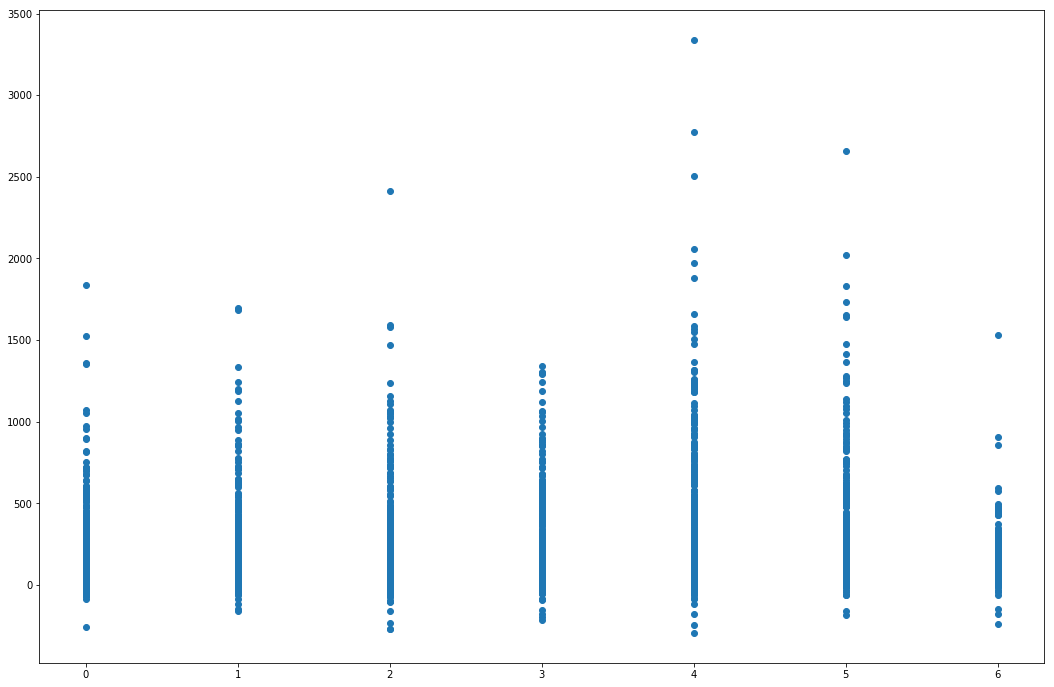

In [137]:
plt.figure(figsize = (18, 12))
plt.scatter(one_stop.weekday, lateness)
plt.show()

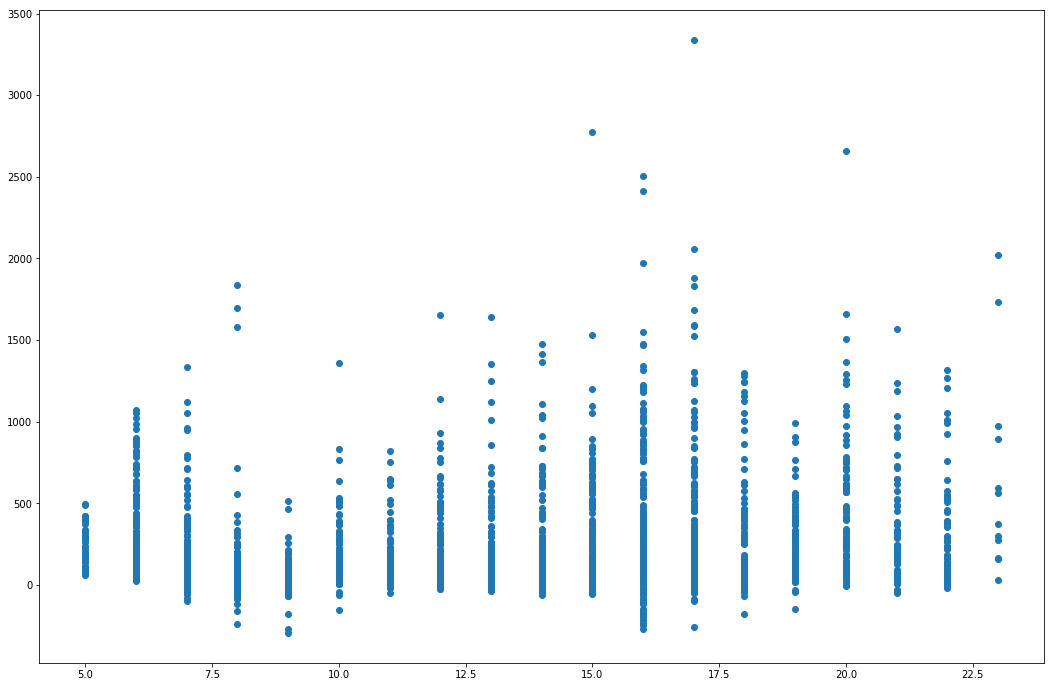

In [138]:
plt.figure(figsize = (18, 12))
plt.scatter(one_stop.hour, lateness)
plt.show()

# Plot ave dwell times

In [42]:
wanted_stops = pat_dict['167_316']
print(len(wanted_stops))
wanted_stops

5


['1290BOB20465', '1290DOB21184', '1200POA10900', '1200POA10897', '9200BOH1']

In [43]:
dwell_stops = veh_events.loc[veh_events['stopCode'].isin(wanted_stops) & ~pd.isnull(veh_events.actualArrival)]

In [44]:
dwell_stops.actualArrival = pd.to_datetime(dwell_stops.actualArrival)
dwell_stops.actualDeparture = pd.to_datetime(dwell_stops.actualDeparture)

dwell_stops['dwellTime'] = dwell_stops.actualDeparture - dwell_stops.actualArrival

C:\Users\Jessica\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [45]:
dwell_stops.dwellTime = dwell_stops.dwellTime.values.astype(np.int64) // 10 ** 9

In [46]:
dwell_stops.date = pd.to_datetime(dwell_stops.date, format='%Y%m%d')
# dwell_stops.actualArrival = pd.to_datetime(dwell_stops.actualArrival)
# add weekdays and hour
dwell_stops['weekday'] = dwell_stops['actualArrival'].dt.dayofweek
dwell_stops['hour'] = dwell_stops['actualArrival'].dt.hour

C:\Users\Jessica\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Jessica\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


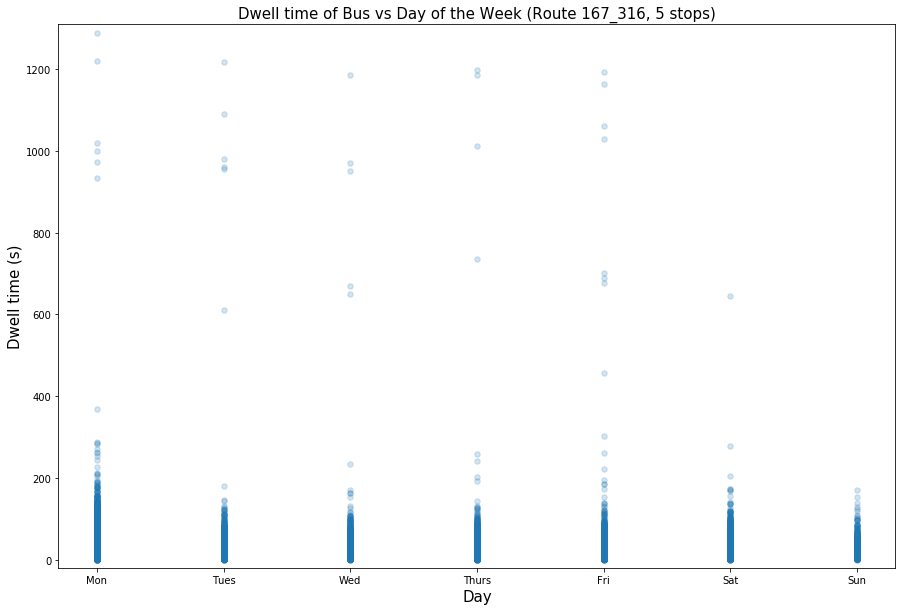

In [47]:
plt.figure(figsize = (15, 10))
plt.scatter(dwell_stops.weekday, dwell_stops.dwellTime, s=30, alpha=0.2)

x1 = [0, 1, 2, 3, 4, 5, 6]
days = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
ax = plt.axes()
ax.set_xticks(x1)
ax.set_xticklabels(days)

plt.title('Dwell time of Bus vs Day of the Week (Route 167_316, 5 stops)', fontsize=15)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Dwell time (s)', fontsize=15)
plt.ylim(-20, 1310)

plt.show()

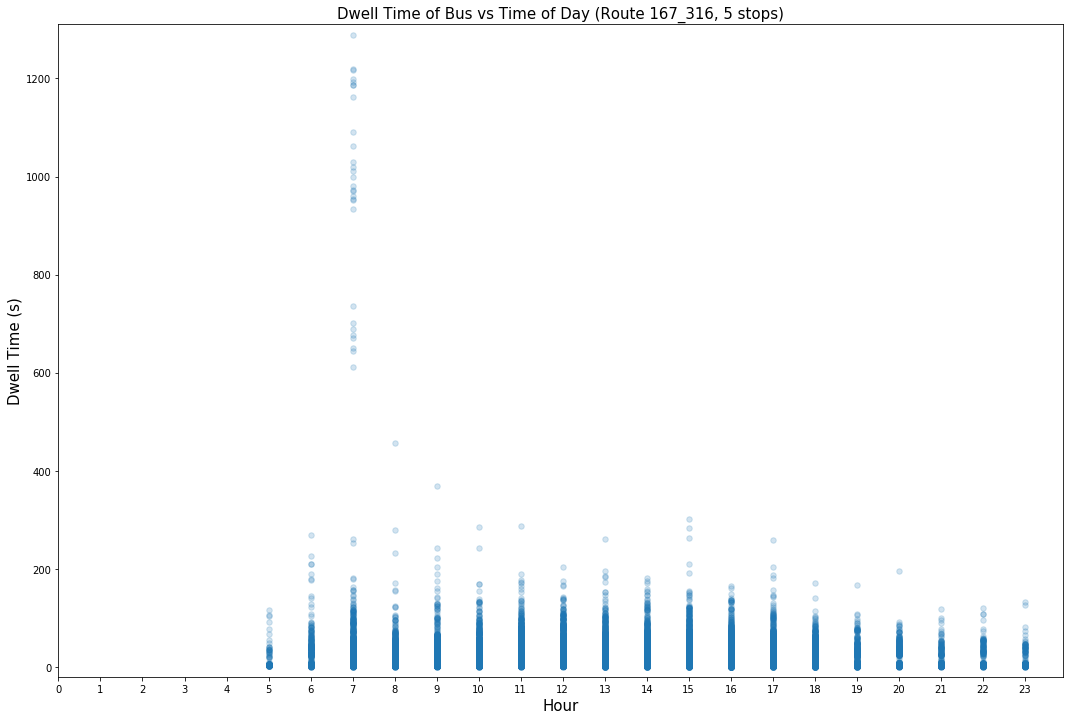

In [53]:
plt.figure(figsize = (18, 12))
plt.scatter(dwell_stops.hour, dwell_stops.dwellTime, s=30, alpha=0.2)

plt.xticks(np.arange(0, 24, 1.0))

plt.title('Dwell Time of Bus vs Time of Day (Route 167_316, 5 stops)', fontsize=15)
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Dwell Time (s)', fontsize=15)
plt.ylim(-20, 1310)

plt.show()

# Plot travel times between consecutive nodes

In [104]:
# This cell to work out travel time between two consecutive stops

def tt_cons_nodes(pat, fst_node, print_out=False):
    """ Fn to calculate the travel times between two consecutive nodes. 
        Returns one array of travel time in seconds 
        and another array of [day, hour]. """
    snd_node = find_next_node(pat, fst_node)
    # check that the node is only visited once in a pattern.
    if len(snd_node) == 66:
        return snd_node
    else:
        if veh_events2.actualArrival.dtype == 'O':
            veh_events2.actualArrival = pd.to_datetime(veh_events2.actualArrival)
        if veh_events2.actualDeparture.dtype == 'O':
            veh_events2.actualDeparture = pd.to_datetime(veh_events2.actualDeparture)
        df_fst_node = veh_events2.loc[(veh_events2.patternId == pat) & 
                                      (veh_events2.stopCode == fst_node)].sort_values(by=['date', 'aimedArrival'])
        df_fst_node['weekday'] = df_fst_node['actualDeparture'].dt.dayofweek
        df_fst_node['hour'] = df_fst_node['actualDeparture'].dt.hour
        
        tt = (veh_events2.loc[(veh_events2.patternId == pat) & 
             (veh_events2.stopCode == snd_node)].sort_values(by=['date', 'aimedArrival']).actualArrival.values - 
              df_fst_node.actualDeparture.values)/10**9
        if np.sum(pd.isnull(tt)) == len(tt):
            print('All arrival/departure values were missing')
            return [], []
#             return
    
        tt = tt.astype(int).reshape(-1, 1)
        
        if print_out == True:
            print('tt =', tt)
        
        day_hr = df_fst_node[['weekday', 'hour']].values
        if print_out == True:
            print('day_hr =', day_hr)
        
        # Now remove the NaT values from before
        both = np.concatenate((day_hr, tt), axis=1)
        new_both = [i for i in both.tolist() if i[2] != 0]
        if print_out == True:
            print('new_both =', new_both)
        new_tt = np.asarray(new_both)[:,2].reshape(-1, 1)
        new_day_hr = np.asarray(new_both)[:,:2]
        
        return new_tt, new_day_hr

In [135]:
%%time
route = pat_dict['167_316']
all_tt = []
all_day = []
all_hr = []

for stop in route[:-1]:
    tt, day_hr = tt_cons_nodes('167_316', stop)
    if len(tt) != 0:
        all_tt.append(tt.reshape(-1,).tolist())
        all_day.append(day_hr[:,0].tolist())
        all_hr.append(day_hr[:,1].tolist())
    print('Done for stop', stop)
    
all_tt = [item for sublist in all_tt for item in sublist]
all_day = [item for sublist in all_day for item in sublist]
all_hr = [item for sublist in all_hr for item in sublist]

Done for stop 1290BOB20465
Done for stop 1290DOB21184
Done for stop 1200POA10900
All arrival/departure values were missing
Done for stop 1200POA10897
Wall time: 5.13 s


C:\Users\Jessica\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


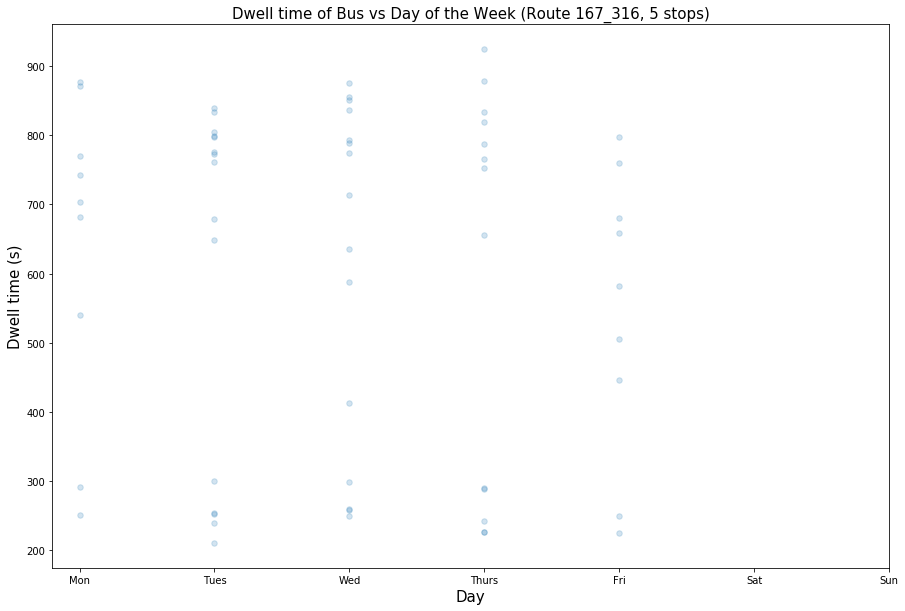

In [136]:
plt.figure(figsize = (15, 10))
plt.scatter(all_day, all_tt, s=30, alpha=0.2)

x1 = [0, 1, 2, 3, 4, 5, 6]
days = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
ax = plt.axes()
ax.set_xticks(x1)
ax.set_xticklabels(days)

plt.title('Travel time of Bus vs Day of the Week (Route 167_316, 5 stops)', fontsize=15)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Dwell time (s)', fontsize=15)

plt.show()

In [138]:
# Actually, how much sense does it make to plot the travel times between multiple stops?

In [139]:
# Want to find a popular link
sorted_dict

[('167_316',
  ['1290BOB20465',
   '1290DOB21184',
   '1200POA10900',
   '1200POA10897',
   '9200BOH1']),
 ('167_319',
  ['1290BOB20465',
   '1290BOA05335',
   '1290DOB21054',
   '1200POA11728',
   '9200BOH1']),
 ('167_320',
  ['9200BOH1',
   '1200POA11727',
   '1290DOB21017',
   '1290BOA56564',
   '1290BOB20465']),
 ('167_321',
  ['9200BOH1',
   '1200POA11727',
   '1290DOB21017',
   '1290BOA56564',
   '1290BOB20465']),
 ('170_270',
  ['1200POA10416',
   '1200POA10441',
   '1200POA10443',
   '1200POA10444',
   '1200POA10446']),
 ('167_317',
  ['9200BOH1',
   '1200POA10892',
   '1200BOB20182',
   '1290DOB21183',
   '1290BOB20474',
   '1290BOB20465']),
 ('167_318',
  ['9200BOH1',
   '1200POA10892',
   '1200BOB20182',
   '1290DOB21183',
   '1290BOB20474',
   '1290BOB20465']),
 ('170_269',
  ['1200POA10447',
   '1200POA10445',
   '1200POA10442',
   '1200POA10440',
   '1200POA10419',
   '1200POA10416']),
 ('170_275',
  ['1290BOB20465',
   '1290DOB21184',
   '1200DOB21230',
   '1200POA10900'

In [142]:
veh_events2.loc[(veh_events2.patternId == '168_250') & (veh_events2.stopCode == '1290DOB21057') 
                & (~pd.isnull(veh_events2.actualArrival))]

,date,id,patternId,stopCode,aimedArrival,aimedDeparture,actualArrival,actualDeparture
1724855,20181020,168_125_6,168_250,1290DOB21057,44460,44460,2018-10-20 12:26:50,2018-10-20 12:27:35
1725126,20181020,168_125_12,168_250,1290DOB21057,65280,65280,2018-10-20 18:13:03,2018-10-20 18:14:01
1725447,20181020,168_122_6,168_250,1290DOB21057,40860,40860,2018-10-20 11:21:06,2018-10-20 11:21:12
1725629,20181020,168_122_10,168_250,1290DOB21057,54360,54360,2018-10-20 15:12:31,2018-10-20 15:12:36
1725764,20181020,168_128_1,168_250,1290DOB21057,28980,28980,2018-10-20 08:02:40,2018-10-20 08:02:45
1726039,20181020,168_128_7,168_250,1290DOB21057,48960,48960,2018-10-20 13:38:50,2018-10-20 13:38:55
1726546,20181020,168_127_6,168_250,1290DOB21057,45360,45360,2018-10-20 12:37:00,2018-10-20 12:37:43
1726910,20181020,168_126_2,168_250,1290DOB21057,31380,31380,2018-10-20 08:42:23,2018-10-20 08:42:30
1727000,20181020,168_126_4,168_250,1290DOB21057,38160,38160,2018-10-20 10:37:08,2018-10-20 10:37:14
1727182,20181020,168_126_8,168_250,1290DOB21057,51660,51660,2018-10-20 14:21:57,2018-10-20 14:22:39


In [144]:
tt, day_hr = tt_cons_nodes('168_250', '1290DOB21057')

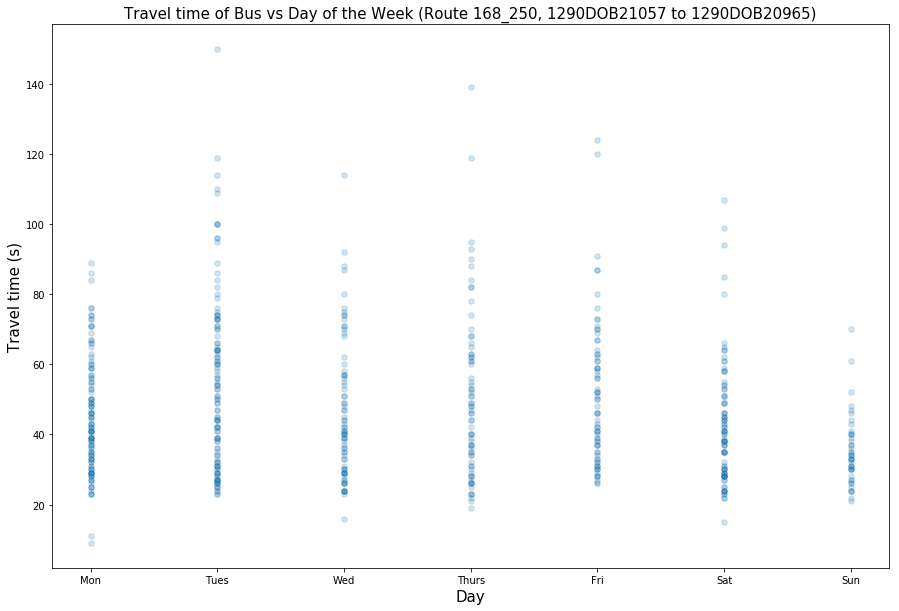

In [148]:
plt.figure(figsize = (15, 10))
plt.scatter(day_hr[:,0], tt.reshape(-1,), s=30, alpha=0.2)

x1 = [0, 1, 2, 3, 4, 5, 6]
days = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
ax = plt.axes()
ax.set_xticks(x1)
ax.set_xticklabels(days)

plt.title('Travel time of Bus vs Day of the Week (Route 168_250, 1290DOB21057 to 1290DOB20965)', fontsize=15)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Travel time (s)', fontsize=15)

plt.show()

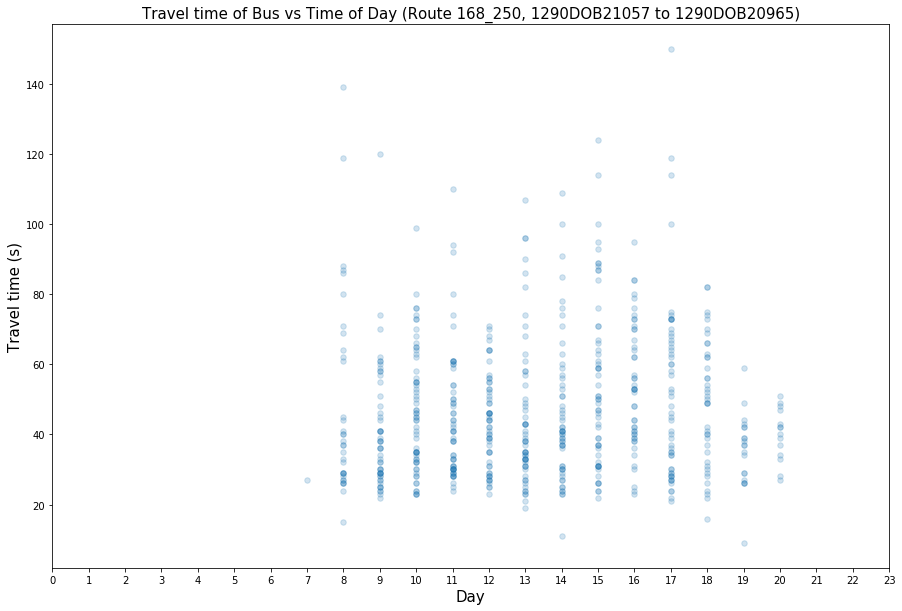

In [149]:
plt.figure(figsize = (15, 10))
plt.scatter(day_hr[:,1], tt.reshape(-1,), s=30, alpha=0.2)

plt.xticks(np.arange(0, 24, 1.0))

plt.title('Travel time of Bus vs Time of Day (Route 168_250, 1290DOB21057 to 1290DOB20965)', fontsize=15)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Travel time (s)', fontsize=15)

plt.show()